In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
cd/content/gdrive/My Drive/Deep_learning_K&P

/content/gdrive/My Drive/Deep_learning_K&P


# CNN을 이용한 분류 (CIFAR10)

합성곱 신경망(Convolutional Neural Network)를 이용한 이미지 분류

입력데이터를 특정크기의 filter를 이용한 합성곱 연산으로 output feature map을 도출하는 방법

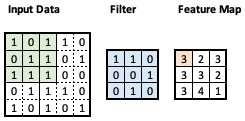

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

## CIFAR10 데이터 불러오기

In [4]:
# CIFAR10: 클래스 10개를 가진 이미지 데이터
# 'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True) 

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# CPU/GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda:0 is available.


## CNN 모델 구축

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #  (입력 채널수 3, 출력 채널수 6, 필터크기 5x5 , stride=1(defualt))
        self.pool1 = nn.MaxPool2d(2, 2) #  (필터크기 2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5) #  (입력 채널수 6, 출력 채널수 16, 필터크기 5x5 , stride=1(defualt))
        self.pool2 = nn.MaxPool2d(2, 2) #  (필터크기 2, stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 5x5 피쳐맵 16개를 일렬로 => 16*5*5개의 노드 생성
        self.fc2 = nn.Linear(120, 10) # 120개 노드에서 클래스의 개수만큼 연산

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x))) # conv1 -> ReLU -> pool1
        x = self.pool2(F.relu(self.conv2(x))) # conv2 -> ReLU -> pool2
        x = x.view(-1, 16 * 5 * 5) # 5x5 피쳐맵 16개를 일렬로 만든다.
        x = F.relu(self.fc1(x)) 
        x = self.fc2(x)

        return x

net = Net().to(device)


In [7]:
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)


## 모델 학습하기

In [9]:
criterion = nn.CrossEntropyLoss().to(device) # CrossEntropyLoss는 softmax 계산까지 포함되어 있으므로 모델의 마지막 output node에 별도의 활성화 함수를 사용하지 않아도 된다.
optimizer = optim.Adam(net.parameters())

In [12]:
loss_ = []
n = len(trainloader) 
net.to(device)
net.train()

for epoch in range(10):  # 10번 학습을 진행

    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):

        inputs, labels = inputs.to(device), labels.to(device) # 배치 데이터 
        
        optimizer.zero_grad()

        outputs = net(inputs) # 예측값 산출 
        loss = criterion(outputs, labels) # 손실함수 계산
        loss.backward() # 손실함수 기준으로 역전파 선언
        optimizer.step() # 가중치 최적화

        running_loss += loss.item()

    loss_.append(running_loss / n)    
    print('[%d] loss: %.3f' %(epoch + 1, running_loss / len(trainloader)))

print('Finished Training')

[1] loss: 0.937
[2] loss: 0.901
[3] loss: 0.868
[4] loss: 0.842
[5] loss: 0.820
[6] loss: 0.795
[7] loss: 0.783
[8] loss: 0.763
[9] loss: 0.744
[10] loss: 0.727
Finished Training


In [ ]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

## 모델 저장하기

In [ ]:
PATH = './models/torch_cifar_net.pth' # 모델 저장 경로 
torch.save(net.state_dict(), PATH) # 모델 저장

## 모델 불러오기

In [ ]:
PATH = './models/torch_cifar_net.pth' # 모델 저장 경로 
net = Net().to(device) # 모델 선언
net.load_state_dict(torch.load(PATH)) # 모델 parameter 불러오기

## 모델 정확도(Accuracy) 구하기

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    net.eval()
    
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # 개수 누적(총 개수)
        correct += (predicted == labels).sum().item() # 누적(맞으면 1, 틀리면 0으로 합산)
        
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))